# Introduction to Footprints
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64))
<br>Last Verified to Run: **2020-08-07**
<br>Verified Stack Release: **20.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Understand footprints, and their relationship to detection, and measurement
2. Use methods and attributes from the footprint class to get information like centroids, size, shape, of the footprint
3. Perform operations on footprints, like dilation an errosion
4. Understand the relaitonship between peaks and footprints, and their role in deblending
4. Use footprints to access pixel level data in their parent exposures

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [1]:
%load_ext autoreload
%autoreload

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [2]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-ishasan-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


For this tutorial we'll need the following modules:

In [3]:
%matplotlib inline

import warnings
# Filter some warnings printed by v16.0 of the stack
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay

In [4]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.rcParams['figure.figsize'] = (8.0, 8.0)

# Footprints

To paraphrase from [Bosch et al. (2017)](https://arxiv.org/pdf/1705.06766.pdf), 

> Footprints record the exact above-threshold detection region on a CCD. These are similar to  SExtractor’s “segmentation map", in that they identify which pixels belong to which detected objects

As you might expect, this means footprints are integral to high-level CCD processing tasks&mdash;like detection, measurement, and deblending&mdash;which directly impact science results. Because footprints are so closely related to these very important processes, we will take a close look at them in this notebook.

## The Basics: Footprint Geometry and Location
In the quote above, an analogy was drawn between footprints and segmentation maps, as they both identify above threshold pixels. As we first introduce footprints, we will concentrate on this similarity as it gives us a place to start understanding the location and geometeric properties of footprints. 

In [5]:
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349')

In [6]:
deepCoadd = butler.get("deepCoadd_calexp", dataId={'filter':"HSC-I", 'tract':9615, 'patch':'0,3'})

In [7]:
# set up minimal detection task
config = SourceDetectionTask.ConfigClass()
# detect sources at 10 sigma 
config.thresholdValue = 10       
config.thresholdType = "stdev"   

sourceDetectionTask =   SourceDetectionTask(config=config)

We will use the `detectFootprints` method in `SourceDetectionTask` to find and store the detected footprints in the image

In [8]:
# run detection on our frame
detect_res = sourceDetectionTask.detectFootprints(deepCoadd)

`detect_res` is a `Struct`. `Struct` objects are similar to python dictionaries, in that they have key value pairs. However, here you access the values by using the keys as an attribute. If you are and IDL user, these will remind you of `Structures` in IDL.

In [9]:
detect_res

Struct(positive=<lsst.afw.detection.FootprintSet object at 0x7fe7a15fc1f0>; negative=None; factor=1.0; background=<lsst.afw.math.backgroundList.BackgroundList object at 0x7fe8101fb4d0>; numPos=7270; numPosPeaks=8703; numNeg=0; numNegPeaks=0)

Looking at `detect_res`, we can see that there are attributes associated with sources detected positive (above threshold) and detected negative (below threshold). Let's concentrate on the positive detections for now, so we can look at astrophysical sources. The positive attribute holds a `FootprintSet`, an object that contains all the positively detected footprints. The `numPos` attribute tells us we have 1060 footprints that were detected positive. The `numPosPeaks` attribute tells us 1158 peaks were detected positive. This is because more than one peak can belong to a footprint. We will discuss peaks more fully in a later section, but for now think of them as what they sound like&mdash;the peaks in the surface brightness profile.

In [10]:
# lets grab the above threshold footprints that were detected and assign them to a varriable
fpset = detect_res.positive

the variable `fpset` is a `FootprintSet` object. While it contains many footprints itself, a few more steps are required to obtain individual footprints. Namely, we will ask for a `FootprintSet` to give us a list of footprints, which we can iterate over

In [11]:
fps = fpset.getFootprints()

Now we have drilled our way down to getting our hands on footprints. Lets discuss some of their methods and attributes. To begin, we will concentrate on footprint geometry and location.

In [12]:
# Get the region
# This will return a box with the pixel coordinates of the CCD that the footprint lies on
fps[0].getRegion()

Box2I(minimum=Point2I(0, 11900), dimensions=Extent2I(4100, 4200))

In [13]:
# The center of the footprint, in the x,y coordinates on the CCD chip
fps[0].getCentroid()

Point2D(495.9230769, 11907.94872)

The bounding box of the footprint. This is the smallest rectangle you can enscribe around the footprint. Not all of the pixels in the bounding box are pixels in the footprint, since the footprint is not necessarily rectangular in shape. the BBox will always be inside the region

In [14]:
fps[0].getBBox()

Box2I(minimum=Point2I(486, 11901), dimensions=Extent2I(19, 17))

Get the area of the footprint. **NOTE** this is not the area of the bounding box. It is the number of pixels associated with the footprint.

In [15]:
fps[0].getArea()

234

The shape of a footprint can be calculated. It is assumed to be an ellipse, and the relevent parameters are defined with the quadurpole, $Q_{i,j}$, a matrix containing the second moments, where

$$Q_{i,j} = \int x_i x_j \mathrm{d}x^i \mathrm{d}x^j$$

Notice this definition *does not* include the surface brightness of the detected object. That is to say, the quadropole computed for footprints describes the geometry of the pixels in the footprint, *not* the intensity weighted shape of its detected object.

The elements for a footprint can be computed with the `getShape()` method. Note that the matix is symmetric.

In [16]:
fps[0].getShape()

Quadrupole(ixx=19.549638395792197, iyy=19.330703484549637, ixy=1.86785009861933)

Looking at $Q_{i,j}$, the diagonal elements are close in magnitude, and the off diagonal elements are close to zero. We expect the footprint to be roughly circular. Now that we have all the pertinent information about where the footprint is and what pixels belong to it, we can display it and see if our expectation is true.

## Visualizing Footprints & Heavy Footprints

We get information about which pixels in the footprints bounding box actually belong to the footprint by using its `SpanSet`. The DM stack is object oriented, and often classes inherit or contain other classes. That is ture here too. The spanSet is a collection of `n` `spans`, where each span has `m` elements, where `n` and `m` are the height and width of the bounding box, respectively. 

If an element in a span is zero, this means the pixel is inside the footprint's bounding box but does not belong to the footprint. If an element is one, the pixel is both in the bounding box and associated with the footprint.

Lets dump the output of the spanset from the first footprint in our list

In [17]:
fps[0].getSpans()

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

You can almost see the footprint by looking at the 1's and zeros here. To extract the actual pixel values that correspond to the ones in the span, we need an additional step. At the moment, our footprints can tell you if a pixel belongs to it or not, buthave no way of accessing pixel values on the `deepCoadd`. To remedy this, we will turn our footprint into a `HeavyFootprint`. HeavyFootprints have all of the qualities of Footprints, but additionally 'know' about pixel level data from the deepCoadd image, variance, and mask planes.

In [18]:
# first we domonstrate the footprint is not heavy
fps[0].isHeavy()

False

In [19]:
# we will make all the footprins heavy at the same time by operating on the footprint set
fpset.makeHeavy(deepCoadd.getMaskedImage())
# we have to redefine fps
hfps = fpset.getFootprints()

In [20]:
# prove the footprints are now indeed heavy
hfps[0].isHeavy()

True

In [21]:
# all of the arrays here will be flattend 1D arrays of pixels from the footprint
hfps[0].getImageArray()

array([ 0.21338397,  0.50302523,  0.79589844,  0.96931505,  0.837897  ,
        0.54093397,  0.3266752 ,  0.18796292,  0.12738033,  0.08827379,
        0.00997487, -0.02778273,  0.11494081,  0.02041115,  0.2548515 ,
        0.5701046 ,  0.8121575 ,  1.0059414 ,  1.0631711 ,  0.7483868 ,
        0.5127966 ,  0.37802923,  0.23095958,  0.13252553,  0.10940661,
        0.07729269,  0.09577508,  0.03790284,  0.06748655,  0.07616808,
        0.18087335,  0.3751763 ,  0.5470941 ,  0.8647696 ,  0.8932718 ,
        0.7581762 ,  0.5990072 ,  0.59294903,  0.3958691 ,  0.32131407,
        0.17428507,  0.08845595,  0.06047423,  0.00651265,  0.03046269,
        0.03120935,  0.05526834,  0.07277943,  0.09728742,  0.18141918,
        0.38902017,  0.48031223,  0.5990773 ,  0.72975546,  0.6669434 ,
        0.7890839 ,  0.6935537 ,  0.48291528,  0.3401495 ,  0.28712985,
        0.07422487, -0.01377036,  0.00357043, -0.0511342 ,  0.03278868,
        0.04182586,  0.09113216,  0.17336673,  0.13868926,  0.31

Now we can use the spanset to reassemble the image array into the footprint. Above we saw that the image array is a 1D numpy array-but the footprint itself is 2 dimensional. Fortunately, the span set has an `unflatten` method that we will use, which can rearrange the image array into the proper 2 dimensional shape

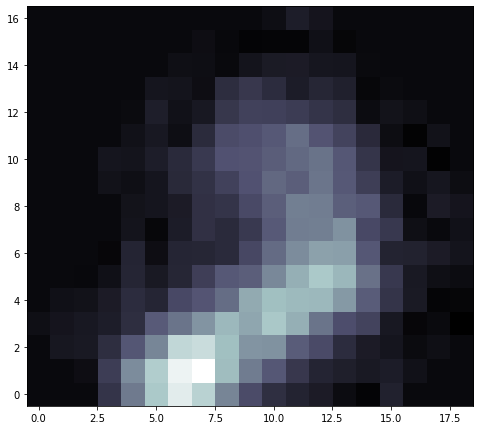

In [22]:
plt.imshow(fps[0].getSpans().unflatten(hfps[0].getImageArray()),
           cmap='bone', origin='lower')

We can do a simmilar exercise with the mask plane values, instead of the image plane values. We can first grab the (flattened) mask plane values of the footprint

In [23]:
hfps[0].getMaskArray()

array([53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296,
       53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296,
       53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296,
       53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296,
       53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296, 53296,
       53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280,
       53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280,
       53280, 36896, 36896, 53280, 53280, 53280, 53280, 53280, 53280,
       53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280, 53280,
       53280, 36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896,
       36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896,
       36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896,
       36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896,
       36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896, 36896,
       36896, 36896,

To understand these values, lets look at the mask plane's dictionary

In [24]:
deepCoadd.getMask().getMaskPlaneDict()

{'BAD': 0,
 'BRIGHT_OBJECT': 9,
 'CLIPPED': 10,
 'CR': 3,
 'CROSSTALK': 11,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 12,
 'INTRP': 2,
 'NOT_DEBLENDED': 13,
 'NO_DATA': 8,
 'REJECTED': 14,
 'SAT': 1,
 'SENSOR_EDGE': 15,
 'SUSPECT': 7,
 'UNMASKEDNAN': 16}

The values are the exponent of the bitmask. So Pixels only marked detected will be 2^5 = 32. Pixels that are both on the edge and detected will be 2^5 + 2^4 = 48. Now we will visualize this in a similar manner to the imshow exercise we did before, only now we are *only* using data for the footprint because we are using the span.

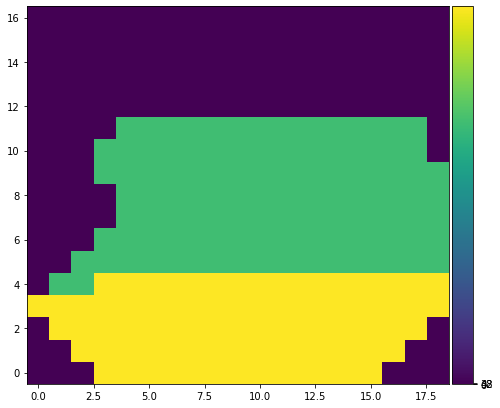

In [25]:
plt.figure(figsize=(8,8))
ax = plt.gca()
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
im = plt.imshow(fps[0].getSpans().unflatten(hfps[0].getMaskArray()),
                origin='lower')

cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax, ticks=[0, 32, 32+16])

## Erosion and Dilation on Footprints

We can grow or shrink footprints by using the `dilate()` and `erode()` methods. You may imagine doing this if you want to ensure you are getting all the flux associated with the detected source, or break apart one big footprint that contains many sources into several which each contain far fewer. Using these methods requires that we provide a scale by which to grow or shrink the footprint. This scale is often related to the PSF scale, e.g., scaling the RMS or $\sigma$ of a gaussian PSF. 

In the dilation process, we can grow out footprint by including its surroundinb pixels. During erosion, we shrinking the object by excluding its outermost pixels. 

Let's demonstrate this below

In [26]:
# first get the gaussian fwhm of the PSF 
psf = deepCoadd.getPsf()
sigma = psf.computeShape().getDeterminantRadius()

# print how many pixels belong to the footprint before we dilate it
print('before dilating the footprint has an area of {}'.format(hfps[0].getArea()))

# now we will grow the footprint by 2 x sigma. We need to pass an int
hfps[0].dilate(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after dilating the footprint has an area of {}'.format(hfps[0].getArea()))

before dilating the footprint has an area of 234
after dilating the footprint has an area of 342


In [27]:
# lets chip away at the footprint by using the erode method now
hfps[0].erode(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after eroding the footprint has an area of {}'.format(hfps[0].getArea()))

after eroding the footprint has an area of 234


To give us some more intuition on how dilation effects the footprints, we will show cut outs of several footprints before they have been dilated (top row) and after they have been dilated. To exagerate the effect, we will use a large scale length in the dilation. Note the change in the range of the x and y axes in these images.

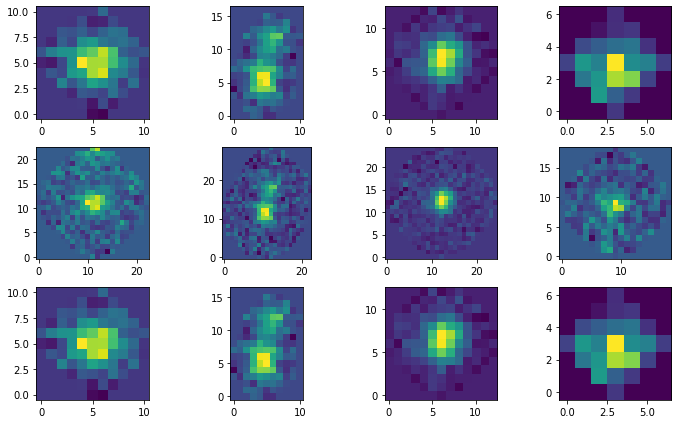

In [28]:
def plot_fp(ax, fp):
    span = fp.getSpans()
    im_data = fp.getImageArray()
    ax.imshow(span.unflatten(im_data), origin='lower')
    return

f, ax = plt.subplots(nrows=3, ncols=4, figsize=(10,6))

# prepare a list with indicies of a few footprints
fp_ids = [100,200,300,400]

# make cut outs of footprints before dilation
for i, j in zip(range(len(fp_ids)), fp_ids):
    plot_fp(ax[0,i], hfps[j])

# dilate footprints
for j in fp_ids:
    hfps[j].dilate(int(5*sigma))

# we need to make the dilated footprints heavy again
# updating the spans by dilation does not automatically update their associated image data
fpset.makeHeavy(deepCoadd.getMaskedImage())
hfps = fpset.getFootprints()

# cut outs of footprints after dilation
for i, j in zip(range(len(fp_ids)), fp_ids):
    plot_fp(ax[1,i], hfps[j])
    
# now lets erode by the same scale so we can demonstrate that 
# erode and dilate are inverses of each other
for j in fp_ids:
    hfps[j].erode(int(5*sigma))

# make them heavy again    
fpset.makeHeavy(deepCoadd.getMaskedImage())
hfps = fpset.getFootprints()

# plot the last row
for i, j in zip(range(len(fp_ids)), fp_ids):
    plot_fp(ax[2,i], hfps[j])
    
plt.tight_layout()

# Footprints, Peaks and Deblending

In the previous sections, we paid close attention to a fairly bright, isolated sources and their associated footprints that were identified as being above a 10 $\sigma$ threshold. In pratice, especially as we detect with lower thresholds, footprints from a first-pass threshold detection can contain several astronomical objects. This is because the wings of the intensity profiles of individual, but closely packed, sources can bleed into each other, forming one above threshold region, and thus one footprint. 

Formally, pixels which are local maxima in the smoothed image during detection are regarded as peaks, and each peak is assumed to be an astrophysical source. In the subsequent deblending process, the deblender looks at all the peaks in each footprints, and gives them their own deblended child footprint. In addition to identifying realestate to deblended children footprints, the deblender also allocates flux from the parent footprint to its children. As a result, the flux in a deblended heavy footprint will not necessarily equal the flux at the same pixels in its image.

In this section we will examine footprints that contain more than one peak, and the interplay between footprints, peaks, and deblending. To do so, we will read footprints from data that has already gone through detection, deblending, and measurement. 

In [29]:
# Let's grab the calexp and source catalog
deepCoadd = butler.get('deepCoadd', dataId={'filter':"HSC-I", 'tract':9615, 'patch':'0,3'})
cat = butler.get('deepCoadd_meas', dataId={'filter':"HSC-I", 'tract':9615, 'patch':'0,3'})

In the following few cells, we will use a few `afwTable` tricks. Because we are interested in understanding peaks and deblending, we are going to sort the source catalog to find the source with the largest number of deblended children. You can learn more about `afwTables` in the [afwTables: A Guided Tour](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/afw_table_guided_tour.ipynb) notebook.

In [30]:
# First get the key for the deblend_nChild field, and id. We need these to sort on them
nChild_key = cat.getSchema().find('deblend_nChild').key
idKey = cat.getIdKey()

# Sort the catalog on number of children
cat.sort(nChild_key)
# The catalog is sorted low to high, so grab the last element
# Use the nChild key to get the number of children, and the id key to get the parent's ID
num_children = cat[-1].get(nChild_key)
parent_id = cat[-1].getId()

# Footprints are stored in the source catalog, we can access them easily
parent_fp = cat[-1].getFootprint()
print('Parent source {} has {} deblended children'.format(parent_id, num_children))

Parent source 42287230089174916 has 48 deblended children


The footprint of the parent object contains catalog of the peaks it contains. This catalog gives the peaks and thier locations and peak pixel value in the *smoothed* image. During the detection process, the image in question is smoothed with a spatial filter. A nice demonstration of this is avaliable in the [LowSurfaceBrightness notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb). The peaks' centers and counts are in this smoothed image, and may differ slightly from their subsequent children footprints after deblending.

In [31]:
parent_fp = cat[-1].getFootprint()

In [32]:
parent_fp.getPeaks()

<class 'lsst.afw.detection.PeakCatalog'>
  id    f_x     f_y   i_x  ... merge_peak_N387 merge_peak_N515 merge_peak_sky
        pix     pix   pix  ...                                               
------ ------ ------- ---- ... --------------- --------------- --------------
 83624 2991.0 14656.0 2991 ...           False           False          False
166693 3047.0 14716.0 3047 ...           False           False          False
166682 3149.0 14682.0 3149 ...           False           False          False
166738 3193.0 14778.0 3193 ...           False           False          False
166694 3012.0 14738.0 3012 ...           False           False          False
166679 3163.0 14675.0 3163 ...           False           False          False
166720 3299.0 14748.0 3299 ...           False           False          False
166685 3128.0 14700.0 3128 ...           False           False          False
166683 3130.0 14691.0 3130 ...           False           False          False
166670 2988.0 14650.0 2

Now we will set up a visualization to see our parent source, the locations of its peaks (as red crosses), and the centers of the deblended children footprints (as orange circles).

In [33]:
# Get the centroid of the parent
parent_x = cat[-1].getX()
parent_y = cat[-1].getY()

parent_x = int(parent_x)
parent_y = int(parent_y)

In [34]:
# Sort the catalog on ID so we can get a view of the 
# catalog that contains the children of the parent source
cat.sort(idKey)
child_cat = cat.getChildren(parent_id)

<Figure size 576x576 with 0 Axes>

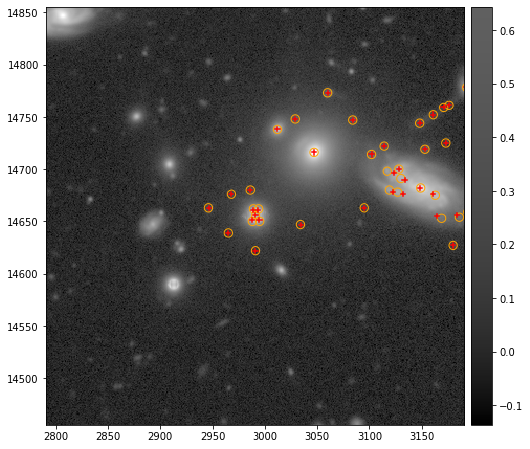

In [35]:
# credit to ADW for this afwDisplay snippet
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.getMaskedImage()[parent_x-200:parent_x+200, parent_y-200:parent_y+200])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

A few comments are in order about the above image.

Even though you can identify by eye there is are several distinct sources here, the detection algorithm lumped them together into one big footprint. Remember, tha is totally fine, as footprints can have one or more "peaks", which correspond to different sources. Take a look at th espiral galaxy in the right side of the image. It has several peaks associated with it, even though by eye we might call it just one large astrophysical source. The deblender shredded this source into several children sources. This is a known failure mode of deblenders. Deblending is hard, and we will not attempt to solve it here, instead opting to restrict our attention to footprints. If you are interested in learning more about deblending beyond the scope of footprints, Fred Moolekamp has prepared [deblending notebooks](https://github.com/LSSTScienceCollaborations/StackClub/tree/master/Deblending) for the StackClub.

The peaks are marked in the detection process. The peaks are formally detections of distinct astrophysical sources. Notice this is different than Source Extractor. although by eye you can tell they are likely just noise peaks. 

The peaks in the parent footprint (red crosses) and  the centers of the deblended children are almost all right about on top of each other. There is, however, a region where there is some miss-match. To see this more clearly, we will re make the plot but zoom in.

<Figure size 576x576 with 0 Axes>

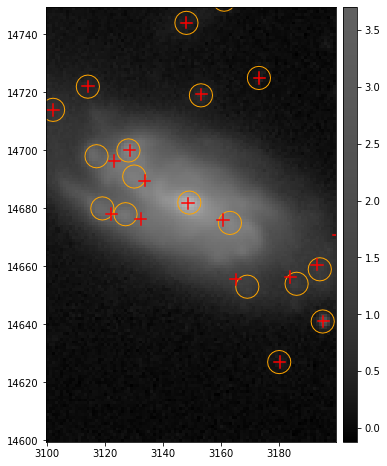

In [36]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.getMaskedImage()[3100:3200, 14600:14750])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

## Effects of Erosion on Peaks, and Contiguity

Now that we have covered erosion/dilation and peaks, we will discuss the interplay between the two. Previously we saw we can change the shape of a footprint by using erosion and dilation operations. Because footprints also contain a list of peaks contained by its span, these operations will in turn effect peaks. Let's continue using the elliptical galaxy with many noise peaks from the previous section. 

We will fist plot the elliptical image data and overlay its peaks with red crosses. Then we will erode the eliptical and see the impact this has on peaks.

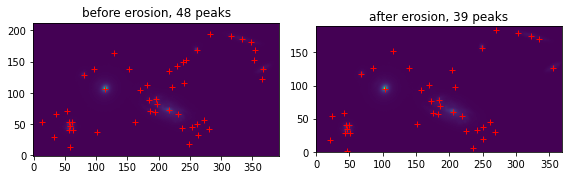

In [37]:
# create a heavy footprint. This will let us grap pixel info from it
heavy_parent_fp = afwDetection.HeavyFootprintF(parent_fp, deepCoadd.getMaskedImage())

f, ax = plt.subplots(ncols=2, nrows=1)

plot_fp(ax[0], heavy_parent_fp)
# iterate over the peaks and overplot them on the image as red crosses
for p in heavy_parent_fp.getPeaks():
    ax[0].plot((p.getIx() - heavy_parent_fp.getBBox().getBeginX()),
            (p.getIy() - heavy_parent_fp.getBBox().getBeginY()), 'r+')
# the title will tell us how many peaks are in the FP before erosion
ax[0].set_title('before erosion, {} peaks'.format(len(heavy_parent_fp.getPeaks())))

# erode the footprint by a large ammount, then repeat the process.
heavy_parent_fp.erode(10)
# assign pixel values to the new eroded heavy footprint
eroded_heavy_parent_fp = afwDetection.HeavyFootprintF(heavy_parent_fp, deepCoadd.getMaskedImage())

plot_fp(ax[1], eroded_heavy_parent_fp)

for p in eroded_heavy_parent_fp.getPeaks():
    ax[1].plot((p.getIx() - heavy_parent_fp.getBBox().getBeginX()),
            (p.getIy() - heavy_parent_fp.getBBox().getBeginY()), 'r+')

ax[1].set_title('after erosion, {} peaks'.format(len(eroded_heavy_parent_fp.getPeaks())))
    
plt.tight_layout()

A few things happened to the footprint after erosion. 

1. Its area decreased, as expected

2. The number of peaks decreased. When you use the `erode` method, any peaks that fall outside the footprint after erosion (called _orphan peaks_ in DM parlance) are discarded. If you happen to alter the span set of a footprint in antother way, you may also use the `removeOrphanPeaks` method by hand to cull any peaks that are outside the span.

3. The footprint was broken up and is no longer contiguous. We can check the contiguity explicitly

In [38]:
eroded_heavy_parent_fp.isContiguous()

False

We can remedy this by using the `split` method on the non-contiguous footprint. This will give us several contiguous footprints, in which all peaks from the initial peak are contained

In [39]:
# split the non-contiguous fp into a vector of contiguous ones
split_fps = eroded_heavy_parent_fp.split()

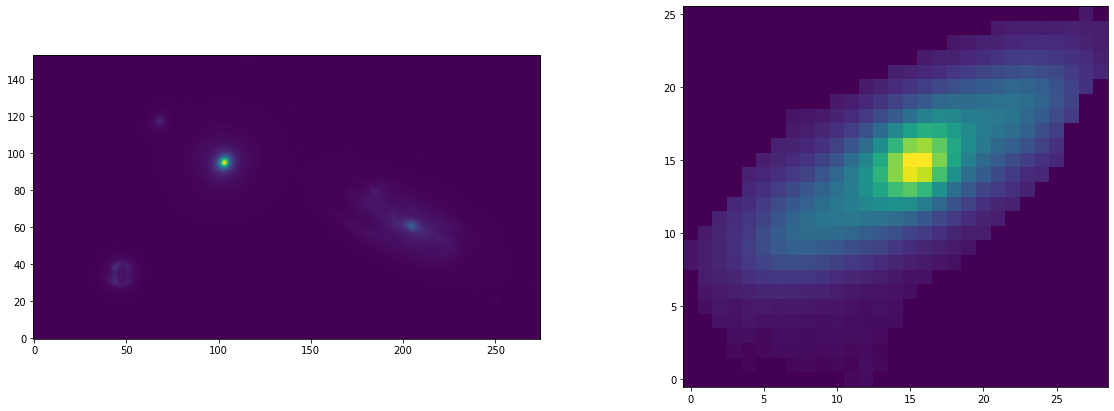

In [40]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# plot up the split fps
plot_fp(ax[0],afwDetection.HeavyFootprintF(split_fps[0], deepCoadd.getMaskedImage()))
plot_fp(ax[1],afwDetection.HeavyFootprintF(split_fps[1], deepCoadd.getMaskedImage()))

We have established that deblending can go wrong, and give us unreliable footprints at times. But how does this impact the measurement process? How much flux actually goes to peaks? We will build our intuition for the impact of deblending on heavy footprints in the next section.

## Footprints, Noise Replacer, and Deblending

As we mentioned at the start of our notebook, footprints work hand in hand with detection, deblending, and measurement. In the following few cells we will loosely follow high level steps that are taken in single frame measurement, so we can understand how footprint deblending can impact measurements and science results.

Refering again to [Bosch et al. (2017)](https://arxiv.org/pdf/1705.06766.pdf), the procedure for source measurement is

> 1. We replace all Footprints in the image with random Gaussian noise with the same variance as the original noise in those pixels.
> 2. We insert the deblended pixels for a particular source to be measured back into the image (replacing the noise pixels).
> 3. We run all measurement plug-ins on the current source.
> 4. We re-replace the Footprint of the current source with noise.
> 5. Repeat this process for the next Footprint

In our discussion below, we will concentrate on one parent footprint, and visualize its deblended children being swapped back in.

In [41]:
# We will sort the source catalog and grab the object that has a bright psf flux and plenty of children
cat.sort(cat.getPsfFluxSlot().getMeasKey())
cat = cat.copy(deep=True)

In [42]:
# the 55th brightest source should be bright enough
# sources much brighter than this tend to be saturated stars,
# but feel free to play around with this
cat.sort(nChild_key)
idx = -55
# verify there are plenty of children
cat[idx].get(nChild_key)

15

In [43]:
# Find the centroid of this source so we can visualize it in a few steps
x, y = cat[idx].getCentroid()
ix = int(x)
iy= int(y)

In [44]:
# grab the parent ID
pId = cat[idx].getId()

Before we start playing around with swapping footprints in and out of the frame, lets take a look at the calexp as it is. We can see a nice bright source at the center, along with a few distinct fainter sources in the background

In [45]:
cat.sort()
children = cat.getChildren(pId)['id']

In [46]:
children

array([42287230089195260, 42287230089195261, 42287230089195262,
       42287230089195263, 42287230089195264, 42287230089195265,
       42287230089195266, 42287230089195267, 42287230089195268,
       42287230089195269, 42287230089195270, 42287230089195271,
       42287230089195272, 42287230089195273, 42287230089195274],
      dtype=int64)

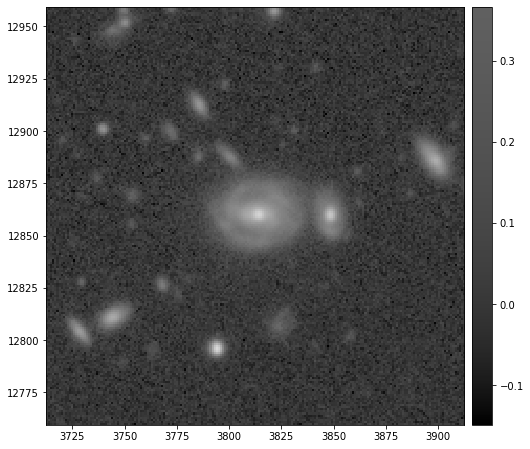

In [47]:
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.getMaskedImage()[ix - 100:ix + 100,iy - 100:iy + 100])

Now we will see how we can exchange the detection footprints with noise by using the `NoiseReplacer` object in the stack. We will emulate steps that are taken in `SingleFrameMeasurementTask`, where measurement algorithms are run on sources. The next two cells are inspired by a few lines from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L305). We will first need to organize our footprints into a dictionary, where the source ID's are the keys and the associated value pairs are the footprints themselves.

We will also point out that you can grab footprints directly from the source catalog.

In [48]:
# prepare footprints in dictionary
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in cat}

In [49]:
# instantiate NoiseReplacer. show it our calexp and footprints
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, deepCoadd, fp_dict)

As we create the `noiseReplacer` object, noise properties are calculated using the pixel values whose associated mask plane pixels have not been set. This noise distribution is used to replace the footprints with generated noise that is supposed to be representative of the true noise properties of the deepCoadd. Now we will display the deepCoadd again to see the result.

<Figure size 576x576 with 0 Axes>

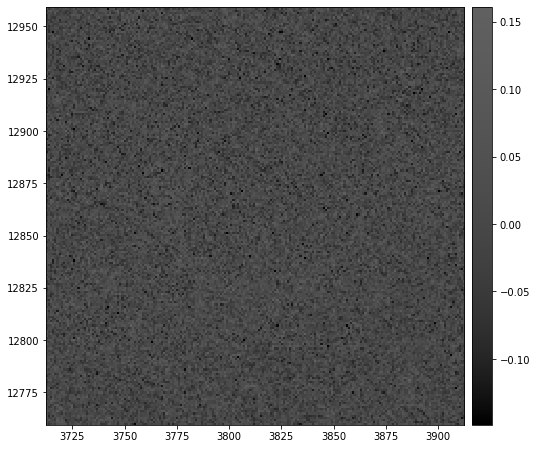

In [50]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.getMaskedImage()[ix-100:ix+100,iy-100:iy+100])

As advertised, we swapped out the data in our footprints with noise. As an aside, if you look closely you can see an 'edge' in the data where the parent object used to be, suggesting perhaps the faint tails of the elliptical's surface brightness profile were missed in detection and now remain in our noise image. We could imagine dilating the footprint to capture these.

Now we will draw some more inspiration from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L353) where we will insert our parent footprint of interest back into the image using its ID from the source catalog.

In [51]:
noiseReplacer.insertSource(pId)

<Figure size 576x576 with 0 Axes>

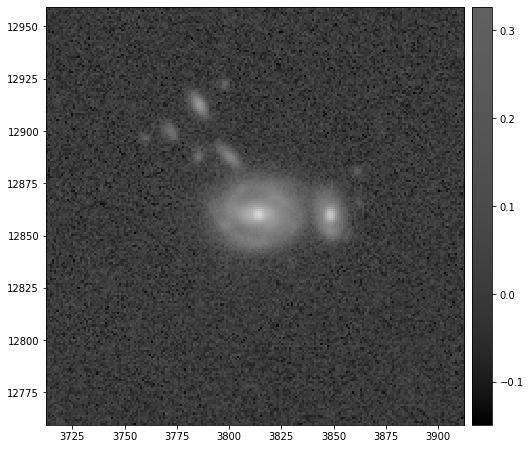

In [52]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.getMaskedImage()[ix-100:ix+100,iy-100:iy+100])

We have used our `NoiseReplacer` instance to ensure this parent footprint is the only source in the image, and all other's have been replaced with noise. The sequence during the measurement process on parent and children footprints would roughly follow like this:

+ The noise replacer swaps out all sources with noise
+ A parent footprint is restored into the image
+ Measurements are run on the parent footprint
+ The parent footprint is replaced with noise
+ A deblended child footprint is restored into the image
+ Measurements are run on the first child

This process would iterate over all parent and child sources. In the next cell we will make a small animation to let us visualize this.

In [53]:
fig = plt.figure()
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

src_ids = [pId] +  children.tolist()

for i in src_ids:
    noiseReplacer.insertSource(i)
    data = deepCoadd.getMaskedImage()[ix-100:ix+100,iy-100:iy+100].getImage().array
    im = plt.imshow(data, origin='lower', animated=True,
                    vmin=0, vmax=5,
                    visible=False)
    ims.append([im])
    noiseReplacer.removeSource(i)

# the plt.close catches a spurious extra image
plt.close()

# makes an animation of the parent, then child footprints
HTML(animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000).to_jshtml())
# takes a minute to get going, 

At first glance, in the animation above it seems the deblending of the central bright galaxies and fainter smaller sources are largely successfully deblended. However, as the movie progresses we can see that the bright spiral galaxy is shredded by the deblender. This is a common failure mode of the deblender. There are peaks in the outer wings of the spiral galaxy; the deblender recieves this list of peaks and assigns flux to them, creating these wispy looking sources that are inserted into the image. Because the deblender conserves flux of the parent source, any flux allocated to the whispy sources from the spiral galaxy is flux that cannot be allocated to the main child footprint of the spiral galaxy.

Now we will show a few cut outs  of the parent (top left), and first few deblended sources.  

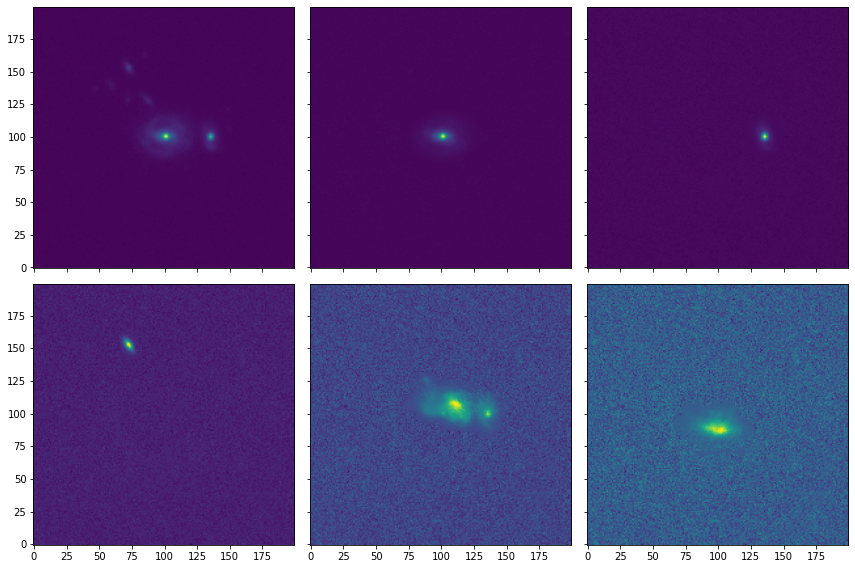

In [54]:
f, ax = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(12,8))

for i, a in zip(range(0, 6), ax.flatten()):
    noiseReplacer.insertSource(src_ids[i])
    data = deepCoadd.getMaskedImage()[ix-100:ix+100,iy-100:iy+100].getImage().array
    a.imshow(data, origin='lower', animated=True)
    noiseReplacer.removeSource(src_ids[i])

plt.tight_layout()

It is good pratice to use the end method for the `NoiseReplacer` after you are finished. This will restore our deepCoadd to the state it was in before we began replacing sources with noise, and so forth

In [55]:
noiseReplacer.end()

## Summary

In this notebook, we learned how to make footprints from detection tasks, create heavy footprints, and access pixel level data from heavy footprints. We also learned the role footprints play in detection, deblending, and measurement.

### Additional resources:

1. [Documentation on footprints](https://github.com/lsst/afw/blob/b4f0cd2fac5183cac01ac5e8ac92be759afed8a3/doc/lsst.afw.detection/Footprint.rst) from the pipelines documentation in the afw package, courtesy Jonathan Sick: 
2. Footprint [Doxygen page](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1detection_1_1_footprint.html)
3. Jim Bosch's [HSC Software Pipeline paper](https://arxiv.org/pdf/1705.06766.pdf), particularly Section 4.8
4. [Low Surface Brightness Stack Club Notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb) by Alex Drlica-Wagner